# LRS-SLIT pipeline tutorial

### by Patrick Kavanagh (DIAS, Ireland) Feb 22th 2019

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS-SLIT data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The pipeline steps are:

2A: dq_init, saturation, linearity, RSCD, firstframe, lastframe, dark_current, refpix, jump, ramp_fitting

2B: assign_wcs, bkg_subtract, flat_field, srctype, photom, extract_1d

The files used in this notebook is an undithered MIRISim simulation of a point source with a blackbody spectrum plus emission lines. A dedicated background observation is also used for subtraction at the level 2 stage. We will run through the steps of the SloperPipeline on the on-source observation only. We will process the background observation using the full pipeline for use in the Spec2Pipeline

In this notebook we will pass the step output to subsequent step input in datamodel form. The output from each step is also writting to a fits file.

#### imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from copy import deepcopy

from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0500.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file, output directory for step outputs:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'LRS-SLIT_demo_data'
input_dir = 'LRS-SLIT_demo_data'

# load all files including the background observation
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_step_output'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()
    

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-FIXEDSLIT	 P750L	 FULL	 2	 50	 FAST	 277.5



Filename: LRS-SLIT_demo_data/det_image_seq2_MIRIMAGE_P750Lexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  SCI           1 ImageHDU        57   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   6420R x 1C   [B]   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/index.html


### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print(dq_init_step.DQInitStep.__doc__)
print(dq_init_step.DQInitStep.spec)


Initialize the Data Quality extension from the
    mask reference file.

    Extended summary
    ----------------
    The dq_init step initializes the pixeldq attribute of the
    input datamodel using the MASK reference file.  For some
    FGS exp_types, initalize the dq attribute of the input model
    instead.  The dq attribute of the MASK model is bitwise OR'd
    with the pixeldq (or dq) attribute of the input model.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)    

### DQ_INIT: run step

In [5]:
# run the dq_init step
dm = dq_init_step.DQInitStep.call(input_files[0], save_results=True, output_use_model=True, 
                                  output_dir=output_dir)


2019-02-22 12:06:03,223 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2019-02-22 12:06:03,269 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('LRS-SLIT_demo_data/det_image_seq2_MIRIMAGE_P750Lexp1.fits',).
2019-02-22 12:06:10,545 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits
2019-02-22 12:06:21,017 - stpipe.DQInitStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_dqinitstep.fits
2019-02-22 12:06:21,018 - stpipe.DQInitStep - INFO - Step DQInitStep done


### DQ_INIT:  output check

1. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the calibration step information
print('Check dq_init step information status:')
print(dm.meta.cal_step.dq_init)

# print unique values in the PIXELDQ extension
print("\nDQ flags values in PIXELDQ:")
print(', '.join(map(str, np.unique(dm.pixeldq))))

# print unique values in the GROUPDQ extension
print("\nDQ flags values in GROUPDQ extension:")
print(', '.join(map(str, np.unique(dm.groupdq))))

Check dq_init step information status:
COMPLETE

DQ flags values in PIXELDQ:
0, 1025, 2049, 16385, 16777216, 16777217, 2147484160

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

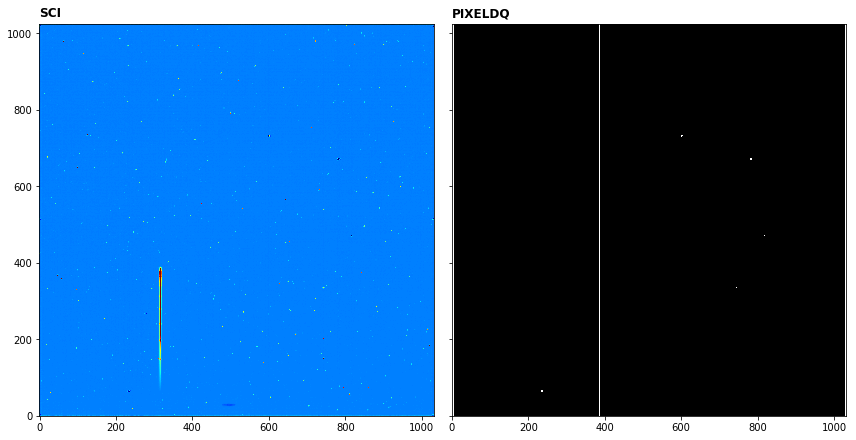

In [7]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/index.html


### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print(saturation_step.SaturationStep.__doc__)
print(saturation_step.SaturationStep.spec)



    This Step sets saturation flags.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = string(default=None)        # Input directory
    


### SATURATION: run step

In [9]:
# run the saturation step
dm = saturation_step.SaturationStep.call(dm, save_results=True, output_use_model=True,
                                         output_dir=output_dir)


2019-02-22 12:06:23,371 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2019-02-22 12:06:23,631 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_dqinitstep.fits>,).
2019-02-22 12:06:23,649 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0022.fits
2019-02-22 12:06:35,370 - stpipe.SaturationStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_saturationstep.fits
2019-02-22 12:06:35,371 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [10]:
# check the calibration step information
print('Check saturation step information status:')
print(dm.meta.cal_step.saturation)

# print unique values in the GROUPDQ extension
print("\nDQ flags values in GROUPDQ extension:")
print(', '.join(map(str, np.unique(dm.groupdq))))
    

Check saturation step information status:
COMPLETE

DQ flags values in GROUPDQ extension:
0


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated

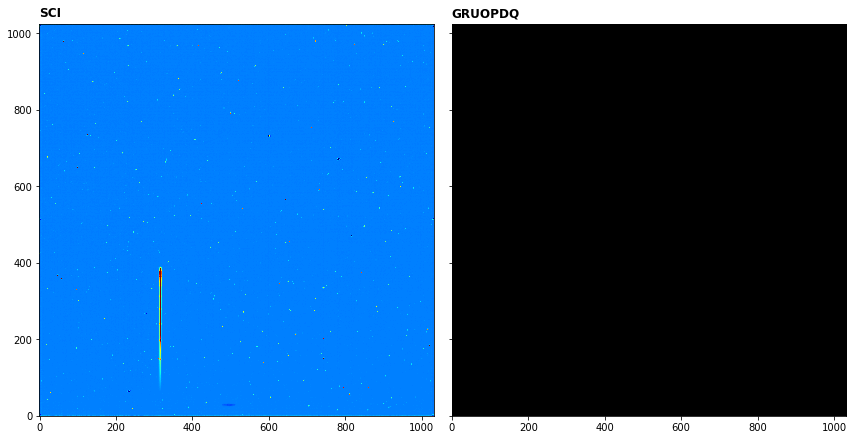

In [11]:
# plot--------------------------------------   
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot last frame of first integration GROUP_DQ
axs[1].imshow(np.sum(dm.groupdq[0],axis=0), cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GRUOPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html


### LINEARITY: load module and show options

In [12]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print(linearity_step.LinearityStep.__doc__)
print(linearity_step.LinearityStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = s

### LINEARITY: run step

In [13]:
# run the linearity step
dm = linearity_step.LinearityStep.call(dm, save_results=True, output_use_model=True,
                                       output_dir=output_dir)


2019-02-22 12:06:39,622 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2019-02-22 12:06:39,685 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_saturationstep.fits>,).
2019-02-22 12:06:39,708 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits
2019-02-22 12:06:48,280 - stpipe.LinearityStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_linearitystep.fits
2019-02-22 12:06:48,281 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  plot output science image to select pixel for inspection

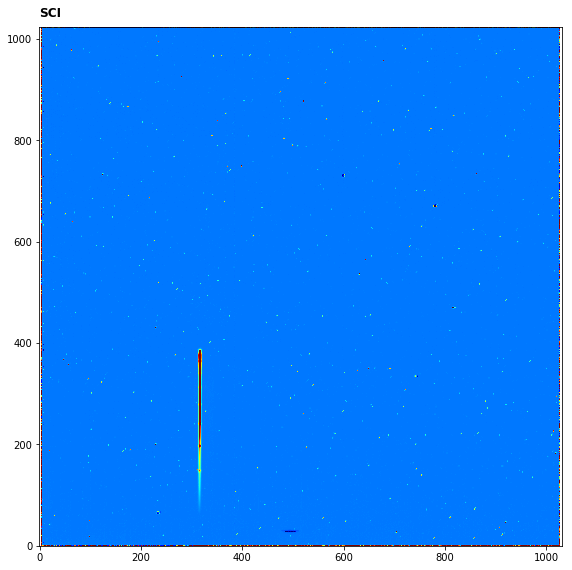

In [14]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

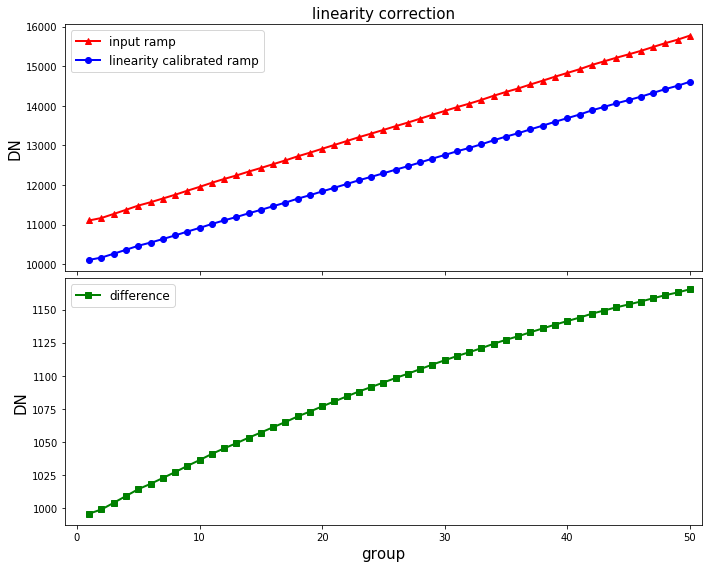

In [15]:
# using image in previous cell, select pixel to check
pixel = [319,267]

# define group numbers for integration ramps
group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', 
            linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', 
            marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html


### RSCD: load module and show options

In [16]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print(rscd_step.RSCD_Step.__doc__)
print(rscd_step.RSCD_Step.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    i

#### RSCD: run step

In [17]:
# run the rscd step
dm = rscd_step.RSCD_Step.call(dm, save_results=True, output_use_model=True,
                              output_dir=output_dir)


2019-02-22 12:06:51,215 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2019-02-22 12:06:51,330 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_linearitystep.fits>,).
2019-02-22 12:06:51,347 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0009.fits
2019-02-22 12:06:53,304 - stpipe.RSCD_Step - INFO -  Working on integration 2
2019-02-22 12:07:00,477 - stpipe.RSCD_Step - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_rscd_step.fits
2019-02-22 12:07:00,479 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  plot output science image to select pixel for inspection

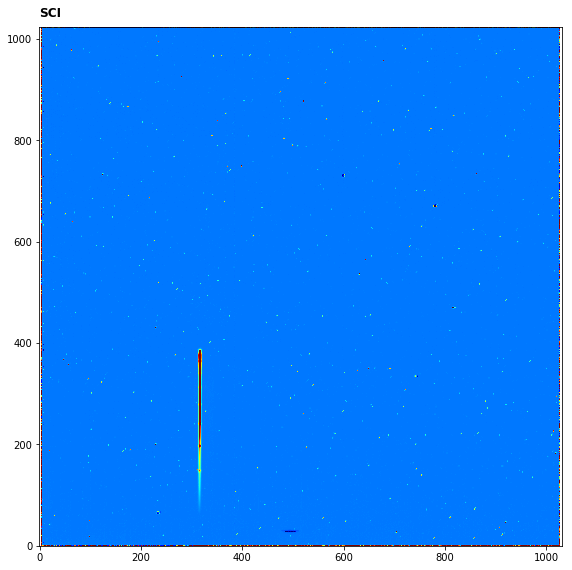

In [18]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


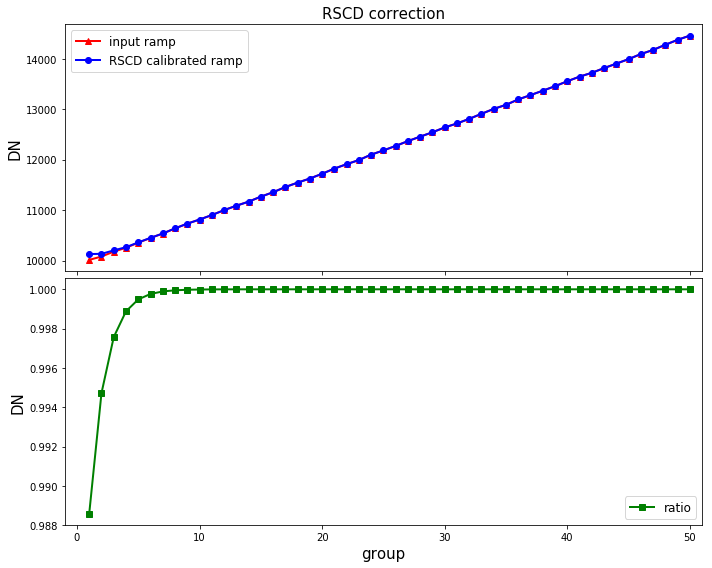

In [19]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

   
# first check that there is more than one integration
if in_dm.data.shape[0] > 1:

    # plot--------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
                linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', 
                linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], c='g', 
                marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: 
    print("RSCD step only operates on exposures with more than one integration.")


## FIRSTFRAME step ==========================================
This step flags the first frame of an integration so it is not used in ramp fitting. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html


### FIRSTFRAME: load module and show options

In [20]:
# import the step
from jwst.firstframe import firstframe_step

# print the description and options
print(firstframe_step.FirstFrameStep.__doc__)
print(firstframe_step.FirstFrameStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FirstFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 3, the DO_NOT_USE group data quality flag is added to
    first group.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in 

### FIRSTFRAME: run step

In [21]:
# run the lastframe step
dm = firstframe_step.FirstFrameStep.call(dm, save_results=True, output_use_model=True, 
                                         output_dir=output_dir)


2019-02-22 12:07:05,222 - stpipe.FirstFrameStep - INFO - FirstFrameStep instance created.
2019-02-22 12:07:05,324 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_rscd_step.fits>,).
2019-02-22 12:07:14,977 - stpipe.FirstFrameStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_firstframestep.fits
2019-02-22 12:07:14,978 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep done


### FIRSTFRAME:  input/output ramp comparison

This correction flags the first frame of an integration so we can check that the first frame has indeed been flagged in the groupDQ extension.

1. plot the first frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that first frame has been flagged

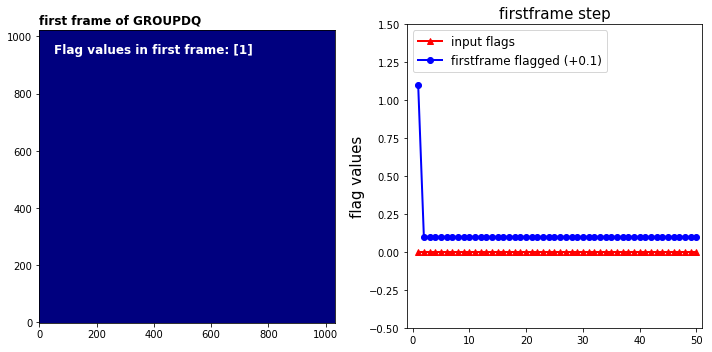

In [22]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[0][0], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('first frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', 
                fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[0][0])
axs[0].annotate('Flag values in first frame: %s' % flag_values, xy=(0.05, 0.92), 
                xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', 
            linewidth=2, label='firstframe flagged (+0.1)')
axs[1].set_title('firstframe step',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()


## LASTFRAME step ==========================================
This step flags the last frame of an integration so it is not used in ramp fitting. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html


### LASTFRAME: load module and show options

In [23]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print(lastframe_step.LastFrameStep.__doc__)
print(lastframe_step.LastFrameStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 2, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile

### LASTFRAME: run step

In [24]:
# run the lastframe step
dm = lastframe_step.LastFrameStep.call(dm, save_results=True, output_use_model=True,
                                       output_dir=output_dir)


2019-02-22 12:07:20,279 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2019-02-22 12:07:20,843 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_firstframestep.fits>,).
2019-02-22 12:07:33,590 - stpipe.LastFrameStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_lastframestep.fits
2019-02-22 12:07:33,590 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

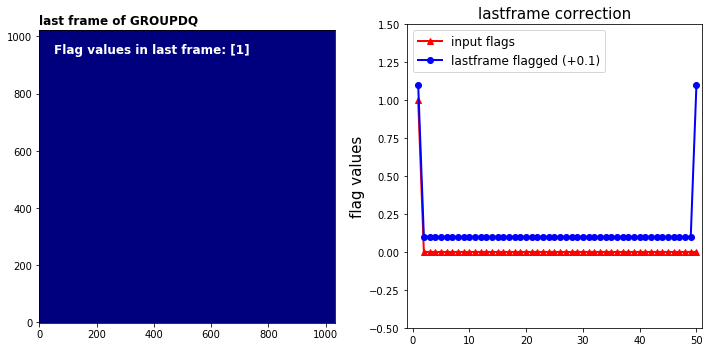

In [25]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the last frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('last frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', 
                fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[-1][-1])
axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), 
                xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', 
            linewidth=2, label='lastframe flagged (+0.1)')
axs[1].set_title('lastframe correction',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/index.html


### DARK_CURRENT: load module and show options

In [26]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print(dark_current_step.DarkCurrentStep.__doc__)
print(dark_current_step.DarkCurrentStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None) # Dark model or averaged dark subtracted
    


### DARK_CURRENT: run step

In [27]:
# run the dark_current step
dm = dark_current_step.DarkCurrentStep.call(dm, save_results=True, output_use_model=True, 
                                            output_dir=output_dir)


2019-02-22 12:07:36,424 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2019-02-22 12:07:36,487 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_lastframestep.fits>,).
2019-02-22 12:07:36,506 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0058.fits
2019-02-22 12:07:56,504 - stpipe.DarkCurrentStep - INFO - Science data nints=2, ngroups=50, nframes=1, groupgap=0
2019-02-22 12:07:56,513 - stpipe.DarkCurrentStep - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-02-22 12:08:06,864 - stpipe.DarkCurrentStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_darkcurrentstep.fits
2019-02-22 12:08:06,865 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done


### DARK_CURRENT:  plot output science image to select pixel for inspection

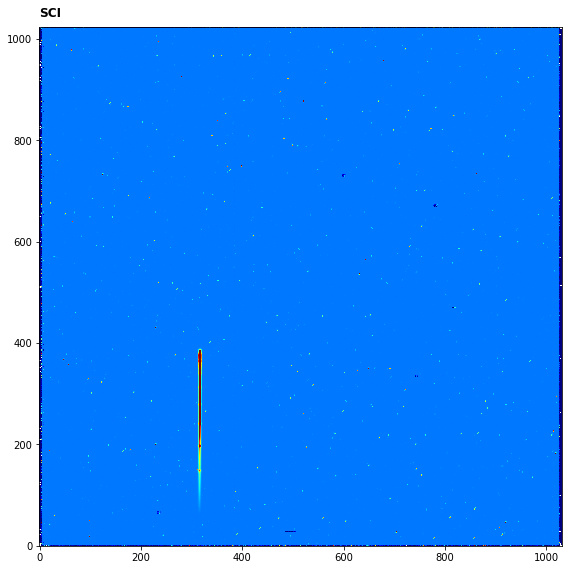

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


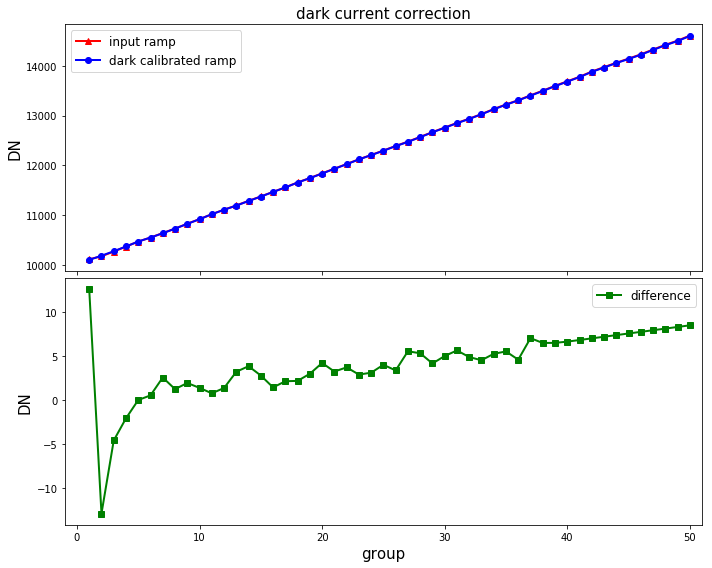

In [29]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', 
            linestyle='-', linewidth=2, label='dark calibrated ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], 
            c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html

Note that this should be skipped for MIRISim data for the time being.


### REFPIX: load module and show options

In [30]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print(refpix_step.RefPixStep.__doc__)
print(refpix_step.RefPixStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [31]:
# run the refpix step
dm = refpix_step.RefPixStep.call(dm, save_results=True, output_use_model=True, 
                                 output_dir=output_dir, skip=True)


2019-02-22 12:08:10,089 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2019-02-22 12:08:10,299 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_darkcurrentstep.fits>,).
2019-02-22 12:08:10,300 - stpipe.RefPixStep - INFO - Step skipped.
2019-02-22 12:08:10,301 - stpipe.RefPixStep - INFO - Step RefPixStep done


### REFPIX:  plot output science image to select pixel for inspection

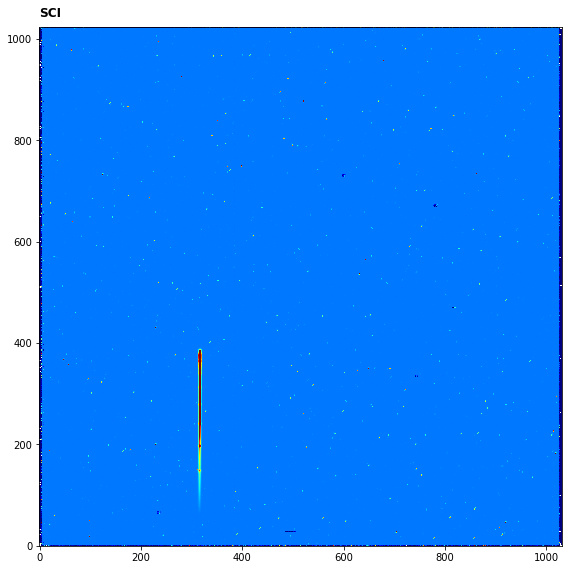

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


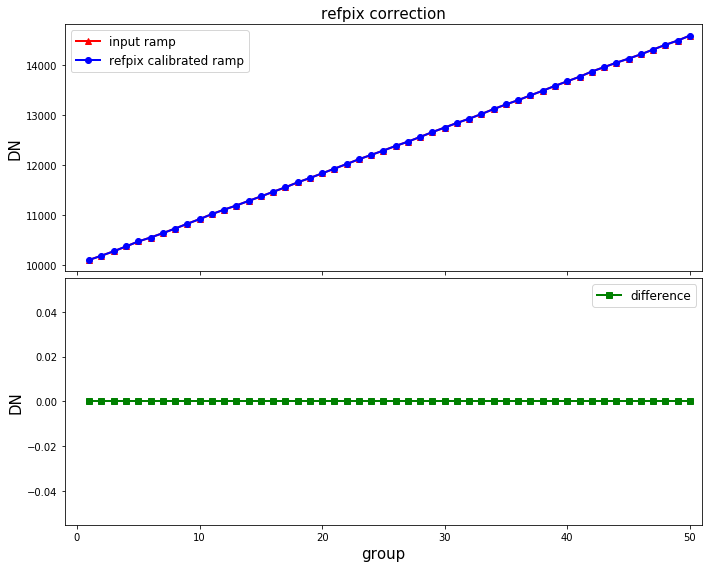

In [33]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]


# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', 
            linewidth=2, label='refpix calibrated ramp')
axs[0].set_title('refpix correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], 
            c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## JUMP correction =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/index.html


### JUMP: load module and show options

In [34]:
# import the step
from jwst.jump import jump_step

# print the description and options
print(jump_step.JumpStep.__doc__)
print(jump_step.JumpStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
    


### JUMP: run step

In [35]:
# run the jump step
dm = jump_step.JumpStep.call(dm, save_results=True, output_use_model=True, 
                             output_dir=output_dir)


2019-02-22 12:08:12,953 - stpipe.JumpStep - INFO - JumpStep instance created.
2019-02-22 12:08:13,027 - stpipe.JumpStep - INFO - Step JumpStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_darkcurrentstep.fits>,).
2019-02-22 12:08:13,043 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2019-02-22 12:08:13,055 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-02-22 12:08:13,200 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-02-22 12:08:15,685 - stpipe.JumpStep - INFO - Executing two-point difference method
2019-02-22 12:08:16,217 - stpipe.JumpStep - INFO -  working on integration 1
2019-02-22 12:08:33,555 - stpipe.JumpStep - INFO -  working on integration 2
2019-02-22 12:09:00,392 - stpipe.JumpStep - INFO - Saved model in LRS-SLIT_demo_data_step

### JUMP:  plot output science image to select pixel for inspection

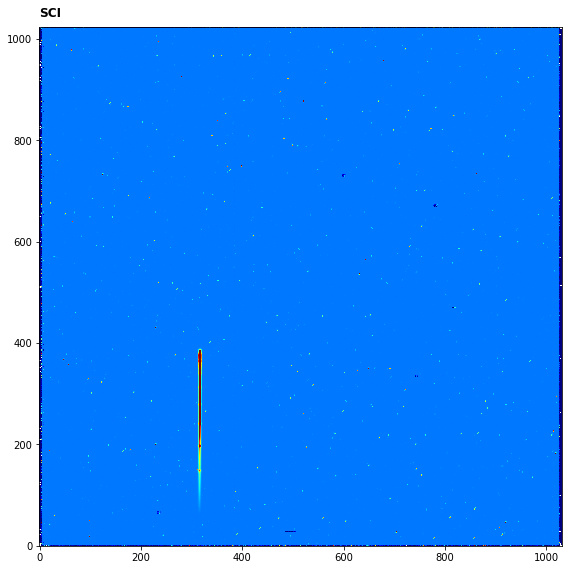

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=2e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ)


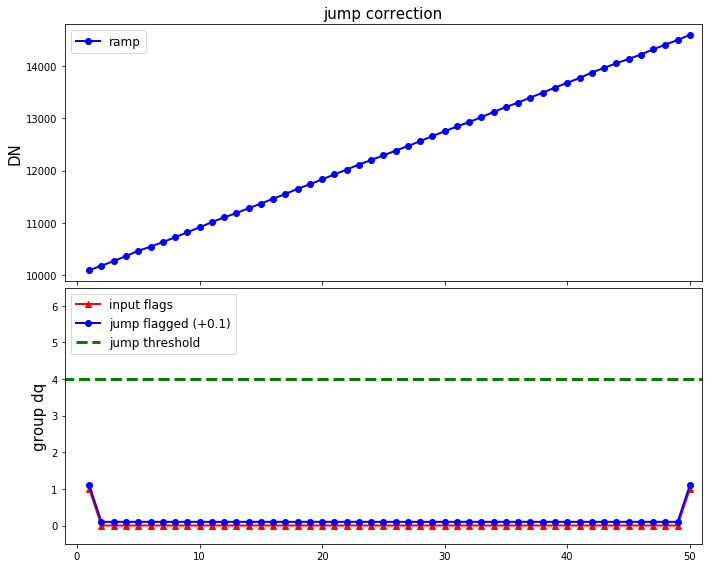

In [37]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# input and output flag values (setting a slight offset for the output flags)
axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', 
            linewidth=2, label='jump flagged (+0.1)')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_ylabel('group dq',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], 
                    linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/index.html

There are two outputs are here:

1) the slope image  (normally ending in _rate.fits)

2) if more than one integration, slope image per integration  (normally ending in _rateints.fits)

This is the last step in the level 2A pipeline.


### RAMP_FITTING: load module and show options

In [38]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print(ramp_fit_step.RampFitStep.__doc__)
print(ramp_fit_step.RampFitStep.spec)



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')
    


### RAMP_FITTING: run step

In [39]:
# run the ramp_fitting step
dm = ramp_fit_step.RampFitStep.call(dm, save_results=True, output_dir=output_dir, 
                                    output_use_model=True)

# copy datamodel for comparison later
level2A_dm = dm[0].copy()


2019-02-22 12:09:01,081 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2019-02-22 12:09:01,223 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_jumpstep.fits>,).
2019-02-22 12:09:01,244 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-02-22 12:09:01,295 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-02-22 12:09:01,320 - stpipe.RampFitStep - INFO - Using algorithm = ols
2019-02-22 12:09:01,320 - stpipe.RampFitStep - INFO - Using weighting = optimal
2019-02-22 12:09:01,324 - stpipe.RampFitStep - INFO - MIRI dataset has all first groups flagged as DO_NOT_USE.
2019-02-22 12:09:01,327 - stpipe.RampFitStep - INFO - MIRI dataset has all final groups flagged as DO_NOT_USE.
2019-02-22 12:09:01,327 - s

### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

2019-02-22 12:14:32,073 - stpipe - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening LRS-SLIT_demo_data/det_image_seq2_MIRIMAGE_P750Lexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)



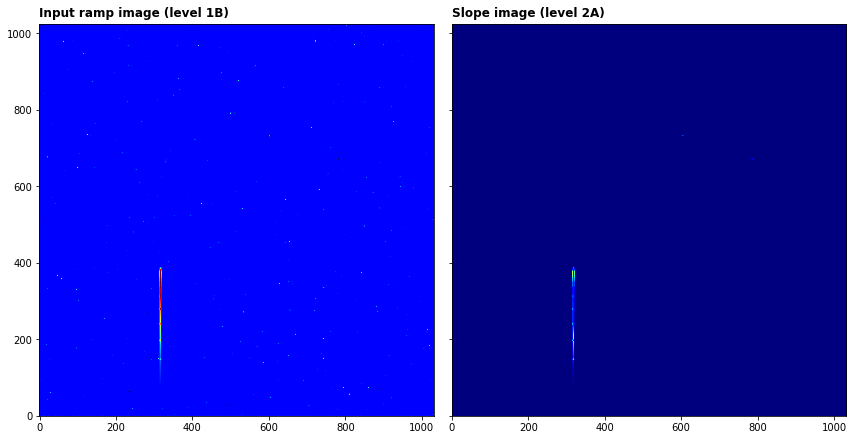

In [40]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
                  norm=LogNorm(vmin=9e3,vmax=5e4))
    axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction', 
                    fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm[0].data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', 
                    fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()
    

## Run level 2A pipeline on the other nod exposure

In [41]:
from jwst.pipeline import Detector1Pipeline

Detector1Pipeline.call(input_files[1], output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})


2019-02-22 12:14:32,883 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-22 12:14:32,885 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-22 12:14:32,887 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-22 12:14:32,888 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-22 12:14:32,890 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-22 12:14:32,891 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-22 12:14:32,893 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-22 12:14:32,895 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-22 12:14:32,897 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-22 12:14:32,898 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-22 

2019-02-22 12:15:17,902 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-02-22 12:15:17,903 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-22 12:15:17,962 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1.fits>,).
2019-02-22 12:15:17,977 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-22 12:15:17,982 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-02-22 12:15:18,121 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-02-22 12:15:20,431 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-22 12:15:20,953 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-22 12:1

<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits>

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html


In [42]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print(assign_wcs_step.AssignWcsStep.__doc__)
print(assign_wcs_step.AssignWcsStep.spec)



    AssignWcsStep: Create a gWCS object and store it in ``Model.meta``.

    Reference file types:

    camera             Camera model (NIRSPEC)
    collimator         Collimator Model (NIRSPEC)
    disperser          Disperser model (NIRSPEC)
    distortion         Spatial distortion model (FGS, MIRI, NIRCAM, NIRISS)
    filteroffset       Filter offsets (MIRI Imager)
    fore               Transform through the FORE optics (NIRSPEC)
    fpa                Transform in the FPA plane (NIRSPEC)
    ifufore            Transforms from the MSA plane to the plane of the IFU slicer (NIRSPEC)
    ifupost            Transforms from the slicer plane to the MSA plane (NIRSPEC)
    ifuslicer          Metrology of the IFU slicer (NIRSPEC)
    msa                Metrology of the MSA plane (NIRSPEC)
    ote                Transform through the Optical Telescope Element (NIRSPEC)
    specwcs            Wavelength calibration models (MIRI, NIRCAM, NIRISS)
    regions            Stores location of th

### ASSIGN_WCS: run step

In [43]:
# run the assign_wcs step
dm = assign_wcs_step.AssignWcsStep.call(dm[0], save_results=True, output_use_model=True,
                                        output_dir=output_dir)


2019-02-22 12:21:24,240 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2019-02-22 12:21:24,297 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_rampfitstep.fits>,).
2019-02-22 12:21:24,357 - stpipe.AssignWcsStep - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/asdf/asdf.py:738: AsdfDeprecationWarning: The method AsdfFile.open has been deprecated and will be removed in asdf-3.0. Use the top-level asdf.open function instead.
  AsdfDeprecationWarning)

2019-02-22 12:21:25,224 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf', 'filteroffset': None, 'specwcs': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0001.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser'

### ASSIGN_WCS:  plot output science image to select pixel for inspection

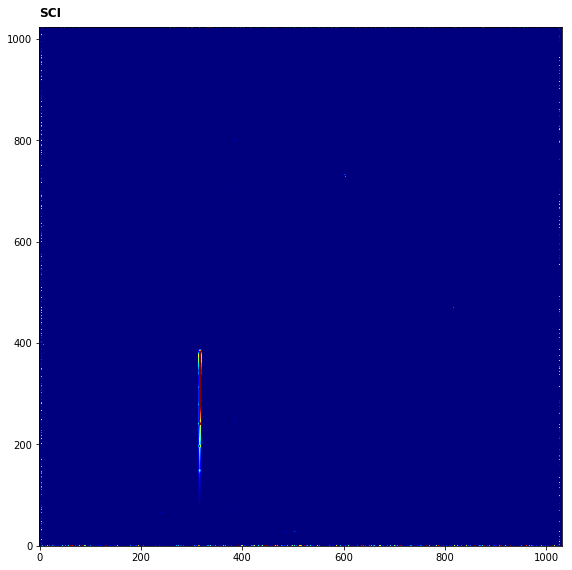

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [45]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# print available coordinate frames
print("Available coordinate frames:")
print(", ".join(dm.meta.wcs.available_frames))
print("")

# perform transforms on pixel
ra, dec, wav = dm.meta.wcs(pixel[0],pixel[1])

print("Pixel: %d, %d" % (pixel[0],pixel[1]))
print("assign_wcs RA, DEC (deg), wavelength: %0.7f %0.7f %0.3f" % (ra,dec, wav))


Available coordinate frames:
detector, world

Pixel: 319, 267
assign_wcs RA, DEC (deg), wavelength: 0.0090482 -0.0008202 9.251


## BACKGROUND step =============================================
The background step subtracts a dedicated background exposure from the target exposure.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/index.html


### BACKGROUND: load module and show options

In [46]:
# import the step
from jwst.background import background_step

# print the description and options
print(background_step.BackgroundStep.__doc__)
print(background_step.BackgroundStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    BackgroundStep:  Subtract background exposures from target exposures.
    

        sigma = float(default=3.0)  # Clipping threshold
        maxiters = integer(default=None)  # Number of clipping iterations
    


### BACKGROUND: run step

In [47]:
# run the background step
bkg_file = glob.glob(os.path.join(output_dir, '*rate.fits'))[0]

dm = background_step.BackgroundStep.call(dm, [bkg_file], save_results=True, output_use_model=True,
                                        output_dir=output_dir)


2019-02-22 12:21:25,812 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2019-02-22 12:21:25,908 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_assignwcsstep.fits>, ['LRS-SLIT_demo_data_step_output/det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits']).
2019-02-22 12:21:26,563 - stpipe.BackgroundStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750Lexp1_backgroundstep.fits
2019-02-22 12:21:26,564 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


### BACKGROUND: check input/output images

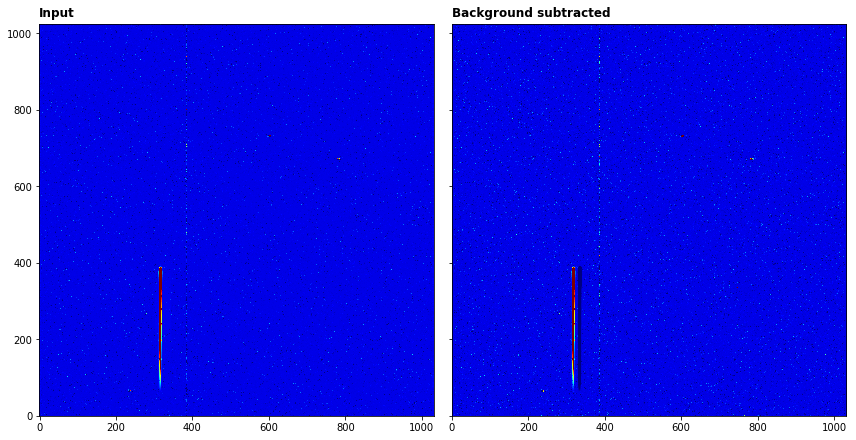

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# sum the groups in the first integration of the input ramp image and plot
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('Input', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('Background subtracted', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html


### FLAT_FIELD: load module and show options

In [49]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print(flat_field_step.FlatFieldStep.__doc__)
print(flat_field_step.FlatFieldStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()

Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        # Note that this is only used for NIRSpec spectrographic data.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [50]:
# run the flat_field step
dm = flat_field_step.FlatFieldStep.call(dm, save_results=True, output_use_model=True,
                                        output_dir=output_dir)
                                        

2019-02-22 12:21:27,119 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2019-02-22 12:21:27,176 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_backgroundstep.fits>,).
2019-02-22 12:21:27,370 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-22 12:21:27,371 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-22 12:21:27,372 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-22 12:21:27,377 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-22 12:21:27,666 - stpipe.FlatFieldStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/det_image_seq2_MIRIMAGE_P750L

### FLAT_FIELD: input/output image checks

1. Display the input and output images
2. Show the ratio of the two

2019-02-22 12:21:27,713 - stpipe - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app



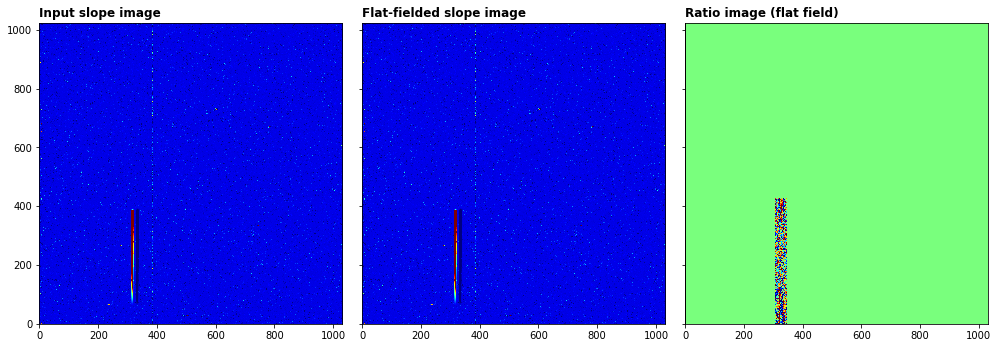

In [51]:
# plot--------------------------------------
# show the input, output and ratio image, 
# which will correspond to the flat field.
fig, axs = plt.subplots(1, 3, figsize=(14, 5),sharey=True)

# show the input
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')

axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

axs[2].imshow(in_dm.data / dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0.995, vmax=1.005)
axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].set_facecolor('black')

plt.tight_layout()
plt.show()

## SRCTYPE step =======================================
This step checks or sets whether a spectroscopic source should be treated as a point or extended object, writing the appropriate value to a keyword. Allowable values are POINT, EXTENDED and UNKNOWN. This will usually be set from the APT by an observer. If the user sets UNKNOWN, a default of POINT is set for the LRS. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/index.html


### SRCTYPE: load module and show options

In [52]:
# import the step
from jwst.srctype import srctype_step

# print the description and options
print(srctype_step.SourceTypeStep.__doc__)
print(srctype_step.SourceTypeStep.spec)



    SourceTypeStep: Selects and sets a source type based on various inputs.
    The source type is used in later calibrations to determine the appropriate
    methods to use. Input comes from either the SRCTYPE keyword value, which
    is populated from user info in the APT, or the NIRSpec MSA planning tool.
    

    


### SRCTYPE: run step

In [53]:
# run the srctype step
dm = srctype_step.SourceTypeStep.call(dm, save_results=True, output_dir=output_dir, 
                                      output_file='srctype_out.fits')

2019-02-22 12:21:28,149 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2019-02-22 12:21:28,211 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_flatfieldstep.fits>,).
2019-02-22 12:21:28,225 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT
2019-02-22 12:21:28,225 - stpipe.SourceTypeStep - INFO - Input SRCTYPE is unknown. Setting to default value of POINT
2019-02-22 12:21:28,445 - stpipe.SourceTypeStep - INFO - Saved model in LRS-SLIT_demo_data_step_output/srctype_out_sourcetypestep.fits
2019-02-22 12:21:28,446 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


### SRCTYPE: check the SRCTYPE keyword value

In [54]:
# print the value of the srctype keyword
print("SRCTYPE: %s" % dm.meta.target.source_type)
    

SRCTYPE: POINT


## PHOTOM step =======================================
This step uses spectroscopic photometric reference files to attach the photometric response to the datamodel. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html

This is the last step in the level 2b pipeline.

### PHOTOM: load module and show options

In [55]:
# import the step
from jwst.photom import photom_step

# print the description and options
print(photom_step.PhotomStep.__doc__)
print(photom_step.PhotomStep.spec)



    PhotomStep: Module for loading photometric conversion infomation from
        reference files and attaching or applying them to the input science
        data model
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define 

### PHOTOM: run step

In [56]:
dm = photom_step.PhotomStep.call(dm, save_results=True, output_use_model=True,
                                 output_dir=output_dir)


2019-02-22 12:21:28,466 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2019-02-22 12:21:28,524 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<ImageModel(1024, 1032) from srctype_out_sourcetypestep.fits>,).
2019-02-22 12:21:28,541 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2019-02-22 12:21:28,543 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2019-02-22 12:21:28,543 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2019-02-22 12:21:28,544 - stpipe.PhotomStep - INFO -  detector: MIRIMAGE
2019-02-22 12:21:28,544 - stpipe.PhotomStep - INFO -  exp_type: MIR_LRS-FIXEDSLIT
2019-02-22 12:21:28,545 - stpipe.PhotomStep - INFO -  filter: P750L
2019-02-22 12:21:28,627 - stpipe.PhotomStep - INFO -  subarray: FULL
2019-02-22 12:21:28,629 - stpipe.PhotomStep - INFO - PHOTMJSR value: 1
2019-02-22 12:21:28,635 - stpipe.PhotomStep - INFO - Storing relative respons

### PHOTOM: check the spectral response has been attached

1. check that the RELSENS attribute has been populated with the response curve

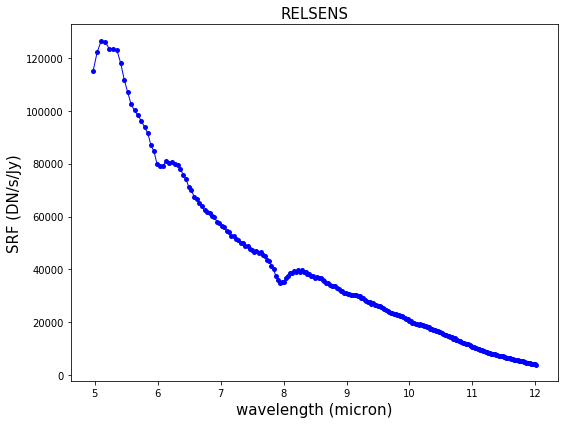

In [57]:
relsens = np.array(dm.relsens, dtype=[('wavelength', 'f4'), ('response', 'i8')])

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# plot input and output ramps of the first integration
axs.plot(relsens['wavelength'], relsens['response'], c='b', marker='o', markersize=2, 
         markeredgewidth=3, linestyle='-', linewidth=1, label='relsens')
axs.set_title('RELSENS', fontsize=15)
axs.set_xlabel('wavelength (micron)', fontsize=15)
axs.set_ylabel('SRF (DN/s/Jy)', fontsize=15)

plt.tight_layout(h_pad=0)
plt.show()

## EXTRACT_1D step ======================================
This step extracts a 1D spectrum from the image. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html


### EXTRACT_1D: load module and show options

In [58]:
# import the step
from jwst.extract_1d import extract_1d_step

# print the description and options
print(extract_1d_step.Extract1dStep.__doc__)
print(extract_1d_step.Extract1dStep.spec)


Extract a 1-d spectrum from 2-d data

    Attributes
    ----------
    ref_file : str
        Name of the reference file.  This can be "N/A" if there is no
        reference file for the current instrument mode.

    smoothing_length : int or None
        If not None, the background regions (if any) will be smoothed
        with a boxcar function of this width along the dispersion
        direction.  This should be an odd integer.

    bkg_order : int or None
        If not None, a polynomial with order `bkg_order` will be fit to
        each column (or row if the dispersion direction is horizontal)
        of the background region or regions.  For a given column (row),
        one polynomial will be fit to all background regions.  The
        polynomial will be evaluated at each pixel of the source
        extraction region(s) along the column (row), and the fitted value
        will be subtracted from the data value at that pixel.
        If both `smoothing_length` and `bkg_order` a

### EXTRACT_1D: run step

In [59]:
spec_dm = extract_1d_step.Extract1dStep.call(dm, save_results=True, output_use_model=True, 
                                             output_dir=output_dir)


2019-02-22 12:21:29,036 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2019-02-22 12:21:29,100 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<ImageModel(1024, 1032) from srctype_out_photomstep.fits>,).
2019-02-22 12:21:29,118 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json
2019-02-22 12:21:29,150 - stpipe.Extract1dStep - WARNING - spectral_order is None; using 1
2019-02-22 12:21:29,161 - stpipe.Extract1dStep - INFO - Total number of dither points = None; assuming no nod/dither offset
2019-02-22 12:21:29,170 - stpipe.Extract1dStep - WARNING - 1 NaNs in wavelength array
2019-02-22 12:21:29,220 - stpipe.Extract1dStep - INFO - Output arrays have been trimmed by 1 elements
2019-02-22 12:21:29,222 - stpipe.Extract1dStep - WARNING - Using RELSENS, 387 elements were extrapolated; these values will be set to 1.
2019-02-22 12:21:29,320 - stpipe.Extract1dSt

### EXTRACT_1D: plot spectrum

While the photom step attaches the SRF to the _cal.fits file, it does not actually apply it so we must manually convert the extracted spectrum from DN/s to Jy using the response in RELSENS. 

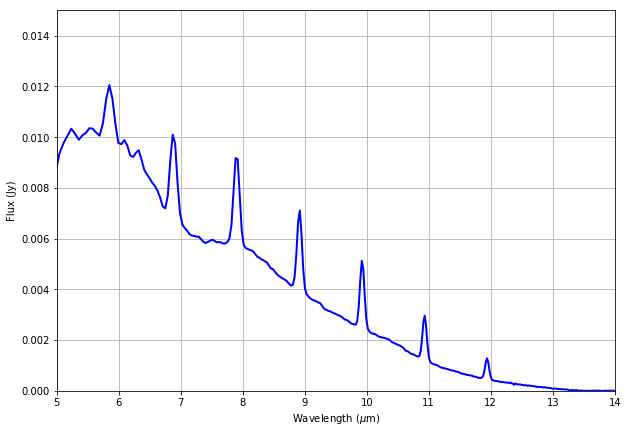

In [60]:
# plot--------------------------------------
# simple XY plot of the spectrum
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

spec = spec_dm.spec[0]
response_at_data = np.interp(spec.spec_table['WAVELENGTH'][1:-1], relsens['wavelength'], relsens['response'])
flux_Jy = spec.spec_table['FLUX'][1:-1] / response_at_data

# plot the spectrum 
axs.plot(spec.spec_table['WAVELENGTH'][1:-1], flux_Jy, c='b', marker='.', 
         markersize=0, linestyle='-', linewidth=2)

axs.set_ylabel(r'Flux (Jy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')
axs.set_xlim(5.0,14.0)
axs.set_ylim(0,0.015)
plt.grid()
plt.show()

Note that this spectrum does not look like the MIRISim input (power law with alpha=0 plus emission lines at integer wavelengths). This is due to known differences in the simulator/pipeline reference files, i.e., some calibration files for the LRS have been updated in MIRISim, but have yet to filter through to the JWST pipeline. As such there are a few discrepancies from expected performance, including:

1. a 0.2-0.3 micron wavelength offset in slit mode. 

2. some flux discrepancies at long wavelengths because of a mis-match between the Spectral Response Function and Photon Conversion Efficiency when compared to the ETC. This mis-match is being investigated.